In [1]:
import os
import re
import json
import utils
import random
import gensim
import warnings

import numpy as np
import pandas as pd

from tasks import *
from pprint import pprint
from tqdm.notebook import tqdm
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
from yellowbrick.cluster import KElbowVisualizer

warnings.filterwarnings('ignore')

/home/tanmay/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
pdf_json = 'data/document_parses/pdf_json/'
filenames = os.listdir(pdf_json)
print("Number of articles retrieved from pdf_json articles:", len(filenames))

Number of articles retrieved from pdf_json articles: 59561


In [4]:
cleaned_files = []

for file in tqdm(os.listdir(pdf_json)):
    filename = pdf_json + file
    file = json.load(open(filename, 'rb'))
    features = [
        file['paper_id'],
        file['metadata']['title'],
        utils.format_authors(file['metadata']['authors']),
        utils.format_authors(file['metadata']['authors'], 
                       with_affiliation = True),
        utils.format_body(file['abstract']),
        utils.format_body(file['body_text']),
        utils.format_bib(file['bib_entries']),
        file['metadata']['authors'],
        file['bib_entries']
    ]
    
    cleaned_files.append(features)
    
    del file
    del features

In [5]:
col_names = [
    'paper_id', 
    'title', 
    'authors',
    'affiliations', 
    'abstract', 
    'text', 
    'bibliography',
    'raw_authors',
    'raw_bibliography'
]

clean_df = pd.DataFrame(cleaned_files, columns = col_names)
del cleaned_files
clean_df.head(2)

,paper_id,title,authors,affiliations,abstract,text,bibliography,raw_authors,raw_bibliography
0,6f005a0677f24f697c1ec3ce065ec4144519e357,Antiviral Mechanisms of Human Defensins Introd...,"Sarah S Wilson, Mayim E Wiens, Jason G Smith","Sarah S Wilson (University of Washington, 1705...",Defensins are an effector component of the inn...,Defensins are one of the most abundant classes...,Direct inactivation of viruses by human granul...,"[{'first': 'Sarah', 'middle': ['S'], 'last': '...","{'BIBREF0': {'ref_id': 'b0', 'title': 'Direct ..."
1,4994fa72322bbf19120592304d92629226948d8e,Rapid Identification of Malaria Vaccine Candid...,"V Villard, G W Agak, G Frank, A Jafarshad, C S...","V Villard, G W Agak, G Frank, A Jafarshad, C S...",To identify malaria antigens for vaccine devel...,Human Plasmodium falciparum (Pf) infection is ...,Identification of vaccine candidates against s...,"[{'first': 'V', 'middle': [], 'last': 'Villard...","{'BIBREF0': {'ref_id': 'b0', 'title': 'Identif..."


In [7]:
clean_df.to_csv("clean.csv")

In [6]:
pmc_dir = 'data/document_parses/pmc_json/'
cleaned_files = []

for file in tqdm(os.listdir(pdf_json)):
    filename = pdf_json + file
    file = json.load(open(filename, 'rb'))
    features = [
        file['paper_id'],
        file['metadata']['title'],
        utils.format_authors(file['metadata']['authors']),
        utils.format_authors(file['metadata']['authors'], 
                       with_affiliation = True),
        utils.format_body(file['abstract']),
        utils.format_body(file['body_text']),
        utils.format_bib(file['bib_entries']),
        file['metadata']['authors'],
        file['bib_entries']
    ]
    
    cleaned_files.append(features)
    
    del file
    del features

  0%|          | 16/43753 [00:01<1:10:23, 10.36it/s]


KeyboardInterrupt: 

In [ ]:
complete_df = pd.concat([clean_df, pmc_df, comm_df, noncomm_df])
complete_df.shape

In [ ]:
complete_df.head(2)

In [ ]:
# Keep only texts with minimal number of words 

complete_df = complete_df[complete_df['text'].apply(lambda x: len(re.findall(r"(?i)\b[a-z]+\b", x))) > 1000]                                           
complete_df.shape

In [15]:
# See random text

complete_df.reset_index(inplace = True, drop = True)
complete_df.iloc[42]['text'][:500]

'The flavivirus Zika virus (ZIKV) activates ribonuclease L (RNase L) catalytic antiviral 26 function during infection, yet deletion of RNase L decreases ZIKV production, suggesting 27 a proviral role of RNase L. In this study, we reveal that latent RNase L supports ZIKV 28 replication factory (RF) assembly. Deletion of RNase L induced broader cellular 29 distribution of ZIKV dsRNA and NS3 compared with densely concentrated RFs detected 30 in WT cells. An inactive form of RNase L was sufficient to'

In [16]:
frac_of_articles = 1
train_df  = complete_df.sample(frac = frac_of_articles, random_state = 42)
train_corpus = (list(utils.read_corpus(train_df, 'abstract'))) 

In [17]:
# Using distributed memory model

model = gensim.models.doc2vec.Doc2Vec(dm = 1, vector_size = 50, min_count = 10, dm_mean = 1, epochs = 20, seed = 42, workers = 6)
model.build_vocab(train_corpus)
model.train(train_corpus, total_examples = model.corpus_count, epochs = model.epochs)

In [18]:
list_of_tasks = [task_1, task_2, task_3, task_4, task_5, task_6, task_7, task_8, task_9]

In [19]:
abstract_vectors = model.docvecs.vectors_docs
array_of_tasks = [utils.get_doc_vector(task, model) for task in list_of_tasks]

In [20]:
train_df['abstract_vector'] = [vec for vec in abstract_vectors]

### Nearest Neigbors search

In [21]:
train_df = train_df[train_df['abstract'].apply(lambda x: len(re.findall(r"(?i)\b[a-z]+\b", x))) > 40]
train_df.shape

(20123, 10)

In [22]:
train_array = train_df['abstract_vector'].values.tolist()

In [23]:
ball_tree = NearestNeighbors(algorithm = 'ball_tree', leaf_size = 20).fit(train_array)

In [24]:
# Query for all tasks

distances, indices = ball_tree.kneighbors(array_of_tasks, n_neighbors = 3)

In [25]:
for i, info in enumerate(list_of_tasks):
    print("="*80, f"\n\nTask = {info[:100]}\n", )
    df =  train_df.iloc[indices[i]]
    abstracts = df['abstract']
    titles = df['title']
    dist = distances[i]
    for l in range(len(dist)):
        print(f" Text index = {indices[i][l]} \n Distance = {distances[i][l]} \n Title: {titles.iloc[l]} \n Abstract extract: {abstracts.iloc[l][:200]}\n\n")


Task = What is known about transmission, incubation, and environmental stability of COVID-19? What do we kn

 Text index = 10154 
 Distance = 5.236969942415397 
 Title: Modeling Control Strategies of Respiratory Pathogens 
 Abstract extract: Effectively controlling infectious diseases requires quantitative comparisons of quarantine, infection control precautions, case identification and isolation, and immunization interventions. We used c


 Text index = 11461 
 Distance = 5.48955226773919 
 Title: Dynamic Transmission Modeling: A Report of the ISPOR-SMDM Modeling Good Research Practices Task Force-5 
 Abstract extract: The transmissible nature of communicable diseases is what sets them apart from other diseases modeled by health economists. The probability of a susceptible individual becoming infected at any one poi


 Text index = 5139 
 Distance = 5.556756137886714 
 Title: Dynamic airflow simulation within an isolation room 
 Abstract extract: In many hospitals, isolation rooms ar

### Clustering and visualisation

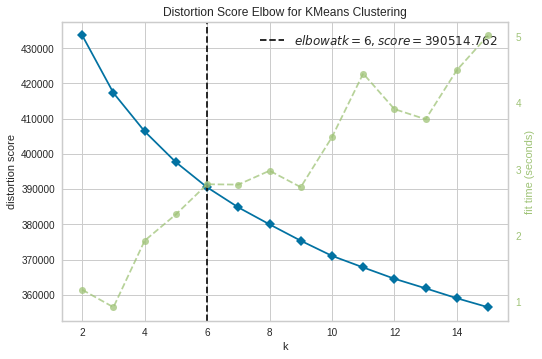

In [26]:
abstract_vectors = model.docvecs.vectors_docs
kmeans = KMeans(init = 'k-means++', max_iter = 300, random_state = 42) 
visualizer = KElbowVisualizer(kmeans, k = (2, 16))
visualizer.fit(abstract_vectors)
visualizer.show()

In [27]:
# Clearly 6 clusters are here

In [28]:
kmeans = KMeans(n_clusters = 6, init = 'k-means++', max_iter = 100, random_state = 42) 
train_df['labels'] = kmeans.fit_predict(train_array)

In [29]:
train_df[['text','labels']][:20]

,text,labels
10352,Although viral disease remains a major cause o...,1
10007,Cationic One research area in the emergent pop...,5
4093,Canine visceral leishmaniasis (CVL) is caused ...,0
5799,Coronaviruses are single stranded positive sen...,5
21052,E merging and re-emerging diseases caused by i...,5
18947,"Presently, lack of proper therapeutics and vac...",5
20653,An essential step in understanding protein fun...,5
7998,"The management of comprehensive and extensive,...",4
16598,Leptospirosis is a worldwide zoonotic disease ...,5
20763,inTrODUcTiOn Porcine epidemic diarrhea (PED) i...,1
